**Evaluation of Regression Models**

In this task, I evaluate additional **metrics** for a **regression model** and compare it with the first model I created. 

Key steps:
1. **Metric Calculation**: Calculate **R², MAE, MAPE, MSE, and RMSE** for both models to assess their prediction **accuracy**.
2. **Visualization**: Visualize the **predicted vs. actual values** and **plot residuals** to assess the **model's performance**.
3. **Model Comparison**: Compare the **final model (ElasticNet**) with the **initial linear regression model** using computed metrics and visualizations.
   
The task demonstrates the **power of feature engineering**, **regularization**, and advanced **regression techniques** in improving model performance.

**🔍 More details and comments are available at the end of the file.**

**#0 Imports**

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# Data splitting and validation
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# Models
from sklearn.linear_model import LinearRegression, ElasticNet

# Metrics
from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)

# Data transformations and processing
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler
)

# Pipeline and column transformations
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

**#1 Load dataset**

In [2]:
bike_data_raw = pd.read_csv('daily-bike-share.csv')
bike_data_raw

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,rentals
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,12/27/2012,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247
727,728,12/28/2012,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644
728,729,12/29/2012,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159
729,730,12/30/2012,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364


**#2 Data preparation**

In [3]:
bike_data_raw['dteday'] = pd.to_datetime(bike_data_raw['dteday'])

In [4]:
bike_data = bike_data_raw.copy()
bike_data.drop(['instant', 'dteday', 'yr'], axis=1, inplace=True)

In [5]:
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit']
target = 'rentals'

In [6]:
bike_data['difference_temp'] = (bike_data['atemp'] - bike_data['temp'])/bike_data['temp']
bike_data.drop(['atemp'], axis=1, inplace=True)
numeric_features = ['temp', 'difference_temp', 'hum', 'windspeed']

In [7]:
print(f'Numeric features: {numeric_features}')
print(f'Categorical features: {categorical_features}')
print(f'Target: {target}')

Numeric features: ['temp', 'difference_temp', 'hum', 'windspeed']
Categorical features: ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
Target: rentals


**#3 First model**

In [8]:
X = bike_data[['temp']].copy()
y = bike_data[target].copy()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f'X.shape: {X.shape}, y.shape {y.shape}')
print()
print(f'X_train.shape: {X_train.shape}, y_train.shape {y_train.shape}')
print(f'X_test.shape: {X_test.shape}, y_test.shape {y_test.shape}')

X.shape: (731, 1), y.shape (731,)

X_train.shape: (584, 1), y_train.shape (584,)
X_test.shape: (147, 1), y_test.shape (147,)


In [10]:
lr_model = LinearRegression() # model initialization
lr_model.fit(X_train, y_train) # model training

LinearRegression()

**#4 First model evaluation**

In [11]:
y_predict_train = lr_model.predict(X_train)
y_predict_test = lr_model.predict(X_test)

In [12]:
print(f'Test R^2: {r2_score(y_test, y_predict_test)}')
print(f'Test MAE: {mean_absolute_error(y_test, y_predict_test)}')
print(f'Test MAPE: {mean_absolute_percentage_error(y_test, y_predict_test)}')
print(f'Test MSE: {mean_squared_error(y_test, y_predict_test)}')
print(f'Test RMSE: {sqrt(mean_squared_error(y_test, y_predict_test))}')

Test R^2: 0.19412301357953687
Test MAE: 391.02879410802956
Test MAPE: 2.986492531856051
Test MSE: 397066.9447179113
Test RMSE: 630.1324818781454


**#5 Final model**

In [13]:
cv = KFold(n_splits=5, shuffle=False)

In [14]:
# Split into explanatory variables and target variable
X = bike_data[numeric_features + categorical_features].copy()
y = bike_data[target].copy()

# Split into train and test sets (same as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
numeric_transformer = Pipeline(steps=[
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Creating final Pipeline for training
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', ElasticNet())])

params = {'preprocessor__num__polynomialfeatures__degree': [1, 2, 3, 4, 5],
          'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
          'regressor__l1_ratio': np.arange(0, 1.1, 0.1)}

final_polynomial_regression_gridsearch = GridSearchCV(final_pipeline,
                                                      params,
                                                      scoring='neg_mean_squared_error',
                                                      cv=cv)

final_polynomial_regression_gridsearch.fit(X_train, y_train)
print("\nBest hyperparameters:", final_polynomial_regression_gridsearch.best_params_, "\n")

final_polynomial_regression_model = final_polynomial_regression_gridsearch.best_estimator_
predictions = final_polynomial_regression_model.predict(X_test)


Best hyperparameters: {'preprocessor__num__polynomialfeatures__degree': 1, 'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.4} 



**#6 Final model evaluation**

In [15]:
print(f'Test R^2: {r2_score(y_test, predictions)}')
print(f'Test MAE: {mean_absolute_error(y_test, predictions)}')
print(f'Test MAPE: {mean_absolute_percentage_error(y_test, predictions)}')
print(f'Test MSE: {mean_squared_error(y_test, predictions)}')
print(f'Test RMSE: {sqrt(mean_squared_error(y_test, predictions))}')

Test R^2: 0.5246818862090765
Test MAE: 348.5851935515566
Test MAPE: 0.859331973002823
Test MSE: 234195.93113132005
Test RMSE: 483.9379414050112


**#7 Visual comparison of models**

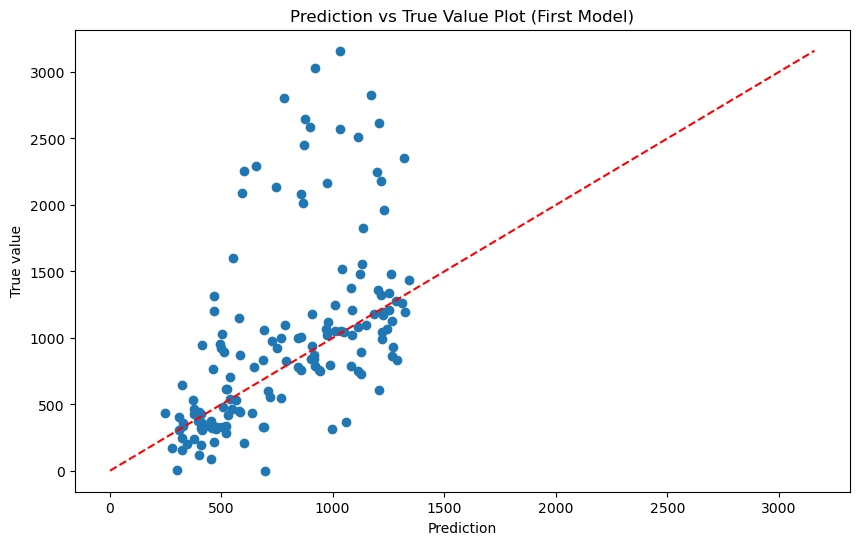

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(x=y_predict_test, y=y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.title('Prediction vs True Value Plot (First Model)')
plt.show()

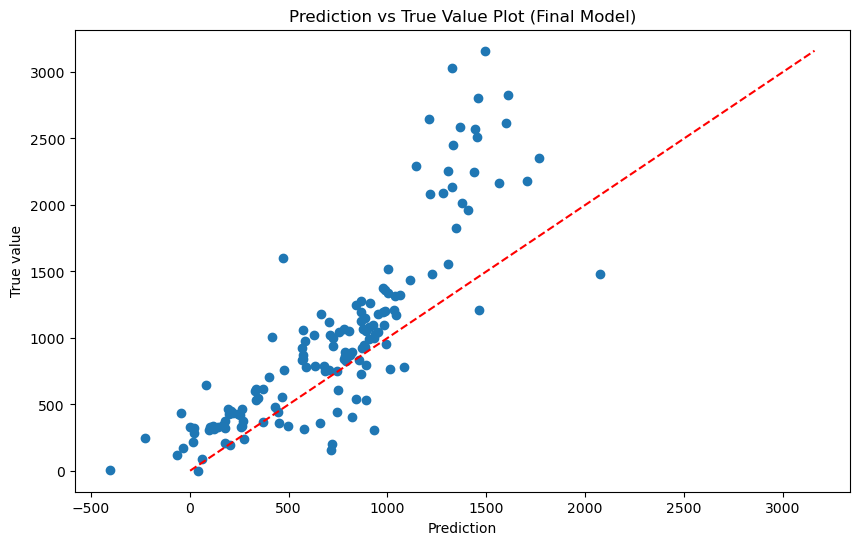

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(x=predictions, y=y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')
plt.xlabel('Prediction')
plt.ylabel('True value')
plt.title('Prediction vs True Value Plot (Final Model)')
plt.show()

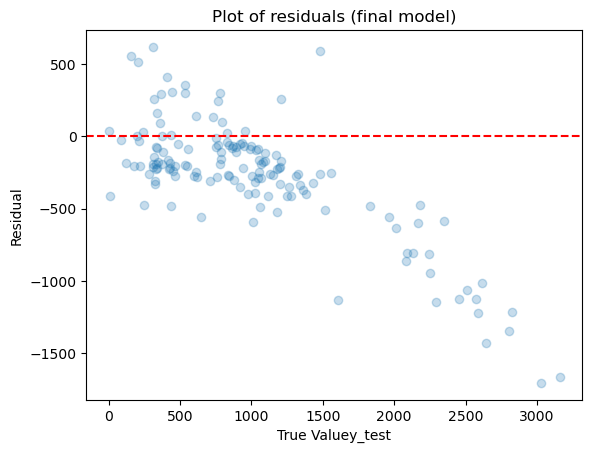

In [18]:
errors = predictions - y_test
plt.scatter(x = y_test, y = errors, alpha=0.25)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel('True Valuey_test')
plt.ylabel('Residual')
plt.title(f'Plot of residuals (final model)')
plt.show()

**#8 Summary**

In [19]:
# Metrics for first model
metrics_first_model = {
    "R^2": round(r2_score(y_test, y_predict_test), 2),
    "MAE": round(mean_absolute_error(y_test, y_predict_test), 2),
    "MAPE": round(mean_absolute_percentage_error(y_test, y_predict_test), 2),
    "MSE": round(mean_squared_error(y_test, y_predict_test), 2),
    "RMSE": round(sqrt(mean_squared_error(y_test, y_predict_test)), 2)
}

# Metrics for final model
metrics_final_model = {
    "R^2": round(r2_score(y_test, predictions), 2),
    "MAE": round(mean_absolute_error(y_test, predictions), 2),
    "MAPE": round(mean_absolute_percentage_error(y_test, predictions), 2),
    "MSE": round(mean_squared_error(y_test, predictions), 2),
    "RMSE": round(sqrt(mean_squared_error(y_test, predictions)), 2)
}

# Displaying results
print("Metrics Comparison:")
print(f"{'Metric':<10} {'First Model':<15} {'Final Model':<15}")
print("-" * 40)
for metric in metrics_first_model.keys():
    print(f"{metric:<10} {metrics_first_model[metric]:<15} {metrics_final_model[metric]:<15}")

Metrics Comparison:
Metric     First Model     Final Model    
----------------------------------------
R^2        0.19            0.52           
MAE        391.03          348.59         
MAPE       2.99            0.86           
MSE        397066.94       234195.93      
RMSE       630.13          483.94         


**#9 Report**

**1. R²**: The first model shows very low model fit, with only **19%** of the variance explained by the model.
The **final model** has a much higher **R² of 52%**, meaning it explains more than half of the variance.
This is a **significant improvement (33%)**, but still, the model needs further enhancement.

**2. MAE**: First model – average prediction error is around **391 units**.
Final model – average prediction error is around **349 units**.
The difference of **42 units** is significant, indicating more precise predictions.

**3. MAPE**: The first model with a score of **2.99** means that, on average, predictions differ from the actual values by **299%**!
The **final model scored 0.86**, indicating the error dropped to **86%**.
A **major improvement (213%)** compared to the first model, indicating much more reliable predictions.

**4. MSE**: The first model has a very high value, indicating large deviations between predictions and actual values.
The final model significantly reduced the squared error.
A **substantial improvement (by 162,871 units)** suggests a better model fit.

**5. RMSE**: The first model: **630.13** – high RMSE value indicates large prediction errors.
The final model: the value decreased to **483.94 units**.
The difference between the models was about **146.19 units**, confirming the improvement in prediction quality.

**In summary**: The final model significantly outperforms the first one across all key metrics, especially **R²**, **MAPE**, and **RMSE**.
The reduction in errors and better fit indicates that the use of advanced techniques (such as polynomials, regularization, and improved feature engineering) brought tangible benefits. However, there is still room for further improvements, especially in increasing the **R² value**.
Comparing the prediction vs actual value plots, the **improvement of the final model** over the first is noticeable. The residual plot still doesn't resemble a perfect "cloud of points" – there's a tendency indicating a linear relationship with a negative slope, suggesting that some relationships in the data remain unexplained by the model. Nonetheless, compared to the initial model, the improvement is evident, and the results are more reliable.
